# Matrix factorisation

In [4]:
from __future__ import print_function, division
from builtins import range, input

In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime

N: 23123 M: 842
epoch: 0
i: 0 N: 23123
i: 2312 N: 23123
i: 4624 N: 23123
i: 6936 N: 23123
i: 9248 N: 23123
i: 11560 N: 23123
i: 13872 N: 23123
i: 16184 N: 23123
i: 18496 N: 23123
i: 20808 N: 23123
i: 23120 N: 23123
updated W and b: 0:00:05.824057
j: 0 M: 842
j: 84 M: 842
j: 168 M: 842
j: 252 M: 842
j: 336 M: 842
j: 420 M: 842
j: 504 M: 842
j: 588 M: 842
j: 672 M: 842
j: 840 M: 842
updated U and c: 0:00:03.425494
epoch duration: 0:00:09.249778
calculate cost: 0:00:00.563126
train loss: 2.614213280040351
test loss: 35.430669084382515
epoch: 1
i: 0 N: 23123
i: 2312 N: 23123
i: 4624 N: 23123
i: 6936 N: 23123
i: 9248 N: 23123
i: 11560 N: 23123
i: 13872 N: 23123
i: 16184 N: 23123
i: 18496 N: 23123
i: 20808 N: 23123
i: 23120 N: 23123
updated W and b: 0:00:05.535364
j: 0 M: 842
j: 84 M: 842
j: 168 M: 842
j: 252 M: 842
j: 336 M: 842
j: 420 M: 842
j: 504 M: 842
j: 588 M: 842
j: 672 M: 842
j: 840 M: 842
updated U and c: 0:00:03.510765
epoch duration: 0:00:09.046337
calculate cost: 0:00:00.504487


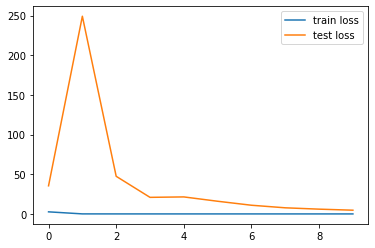

In [6]:
# load in the data
import os
if not os.path.exists('user2product.json') or \
   not os.path.exists('product2user.json') or \
   not os.path.exists('userproduct2rating.json') or \
   not os.path.exists('userproduct2rating_test.json'):
   import preprocess2dict


with open('user2product.json', 'rb') as f:
    user2product = pickle.load(f)

with open('product2user.json', 'rb') as f:
    product2user = pickle.load(f)

with open('userproduct2rating.json', 'rb') as f:
    userproduct2rating = pickle.load(f)

with open('userproduct2rating_test.json', 'rb') as f:userproduct2rating_test = pickle.load(f)


N = np.max(list(user2product.keys())) + 1
# the test set may contain productss the train set doesn't have data on
m1 = np.max(list(product2user.keys()))
m2 = np.max([m for (u, m), r in userproduct2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)


# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(userproduct2rating.values()))

# prediction[i,j] = W[i].dot(U[j]) + b[i] + c.T[j] + mu

def get_loss(d):
    N = float(len(d))
    sse = 0
    for k, r in d.items():
        i, j = k
        p = W[i].dot(U[j]) + b[i] + c[j] + mu
        sse += (p - r)*(p - r)
    return sse / N


# train the parameters
epochs = 10
reg = 0.0001 # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()
    # perform updates
    
    # update W and b
    t0 = datetime.now()
    for i in range(N):
        # for W
        matrix = np.eye(K) * reg
        vector = np.zeros(K)
        
        # for b
        bi = 0
        try:
            for j in user2product[i]:
                r = userproduct2rating[(i,j)]
                matrix += np.outer(U[j], U[j])
                vector += (r - b[i] - c[j] - mu)*U[j]
                bi += (r - W[i].dot(U[j]) - c[j] - mu)
                
            # set the updates
            W[i] = np.linalg.solve(matrix, vector)
            b[i] = bi / (len(user2product[i]) + reg)

            if i % (N//10) == 0:
                print("i:", i, "N:", N)
        except KeyError:
            # possible for a user not to have any ratings for a given product.
            pass
    print("updated W and b:", datetime.now() - t0)

    # update U and c
    t0 = datetime.now()
    for j in range(M):
        # for U
        matrix = np.eye(K) * reg
        vector = np.zeros(K)

        # for c
        cj = 0
        try:
            for i in product2user[j]:
                r = userproduct2rating[(i,j)]
                matrix += np.outer(W[i], W[i])
                vector += (r - b[i] - c[j] - mu)*W[i]
                cj += (r - W[i].dot(U[j]) - b[i] - mu)
            # set the updates
            U[j] = np.linalg.solve(matrix, vector)
            c[j] = cj / (len(product2user[j]) + reg)

            if j % (M//10) == 0:
                print("j:", j, "M:", M)
        except KeyError:
            # possible not to have any ratings for a product
            pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)


    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(userproduct2rating))

    # store test loss
    test_losses.append(get_loss(userproduct2rating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])


print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()